1. [Tiền xử lý dữ liệu](#1-tiền-xử-lý-dữ-liệu)  
   1.1 [Đọc dữ liệu](#11-đọc-dữ-liệu)  
   1.2 [Lọc ra bộ dữ liệu chỉ gồm phòng trọ](#12-lọc-ra-bộ-dữ-liệu-chỉ-gồm-phòng-trọ)  
   1.3 [Xóa các đặc trưng không cần đến](#13-xóa-các-đặc-trưng-không-cần-đến)  
   1.4 [Tạo thêm đặc trưng cho bảng dữ liệu](#14-tạo-thêm-đặc-trưng-cho-bảng-dữ-liệu)  
   1.5 [Xóa những dòng Square = null và Price = null](#15-xóa-những-dòng-square--null-và-price--null)  
   1.6  [Xử lý giá trị của cột Price](#16-xử-lý-giá-trị-của-cột-price)  
   1.7 [Xác định biến Categorical/Numeric](#17-xác-định-biến-categoricalnumeric)  
   1.8 [Loại bỏ outliers](#18-loại-bỏ-outliers)  
   1.9 [Trộn dữ liệu, tách independent/dependent variable, chuẩn hóa dữ liệu](#19-trộn-dữ-liệu-tách-independentdependent-variable-chuẩn-hóa-dữ-liệu)  
   1.10 [Chia tập Train/Val/Test](#110-chia-tập-trainvaltest)  
2. [Xây dựng, huấn luyện, đánh giá model](#2-xây-dựng-huấn-luyện-đánh-giá-model)  

# 1. Tiền xử lý dữ liệu

## 1.1 Đọc dữ liệu

In [626]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from datetime import datetime 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,mean_absolute_error
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
import import_ipynb 
from lib_final import *

In [627]:
# Link crawl data: https://ancu.me/cho-thue-nha-tro-phong-tro-thanh-pho-ho-chi-minh/t1
train_df = pd.read_csv('clean_data.csv')
train_df_temp = train_df.copy()
train_df_temp.head()

,Id,Title,Price,Square,District,City,Date
0,329,Tìm người ở ghép phòng trọ gần ngã 3 Lũy Bán B...,8.4,NaN,Tân Phú,Hồ Chí Minh,2018-05-17
1,1110,"Cho thuê phòng trọ 25m2, giờ tự do hẻm 137 Trị...",2.5,25.0,Tân Phú,Hồ Chí Minh,2018-05-14
2,1114,Chuyên cho thuê CH Era Town có thể dọn vào ở l...,2.0,15.0,Quận 7,Hồ Chí Minh,2018-05-14
3,1275,"Phòng gác lửng, máy lạnh, ban công, WC riêng, ...",3.7,NaN,Quận 7,Hồ Chí Minh,2018-05-14
4,1592,Cho thuê phòng full nội thất cho nữ trong căn ...,3.8,NaN,Nhà Bè,Hồ Chí Minh,2018-05-14


## 1.2 Lọc ra bộ dữ liệu chỉ gồm phòng trọ 
> Ở cột 'Title', có rất nhiều loại phòng cho thuê: phòng trọ, kí túc xá, nhà, chung cư. Ở đồ án này, nhóm chỉ tập trung vào dự đoán giá cho thuê phòng trọ.

In [628]:
train_df_temp = title_clean('Title', train_df_temp)

## 1.3 Xóa các đặc trưng không cần đến

In [629]:
train_df_temp.drop('City', axis= 1, inplace = True)
train_df_temp.drop('Date', axis= 1, inplace = True)

## 1.4 Tạo thêm đặc trưng cho bảng dữ liệu 
> Dựa vào đặc trưng: 'Title' để tạo thêm 3 đặc trưng: isNew, hasFurniture và liveTogether

In [630]:
train_df_temp = isNew('Title', train_df_temp)
train_df_temp = hasFurniture('Title', train_df_temp)
train_df_temp = liveTogether('Title', train_df_temp)
train_df_temp.head()

,Id,Title,Price,Square,District,isNew,hasFurniture,liveTogether
0,329,tìm người ở ghép phòng trọ gần ngã 3 lũy bán b...,8.4,NaN,Tân Phú,no,no,yes
1,1110,"cho thuê phòng trọ 25m2, giờ tự do hẻm 137 trị...",2.5,25.0,Tân Phú,no,no,no
2,2618,cho thuê phòng trọ mới xây tại 377/8/34 bạch đ...,3.0,20.0,Bình Thạnh,yes,no,no
3,3880,cho thuê phòng trọ mới giá rẻ đường chu văn an...,3.3,22.0,Bình Thạnh,yes,no,no
4,4182,"cho thuê phòng trọ hẻm 283 huỳnh tấn phát, kcx...",2.5,13.5,Quận 7,no,no,no


## 1.5 Xóa những dòng Square = null và Price = null

In [631]:
train_df_temp = train_df_temp[train_df_temp["Square"].notna()]
train_df_temp = train_df_temp[train_df_temp["Square"].notna()]

## 1.6 Xử lý giá trị của cột Price

In [632]:
# Lúc thu thập dữ liệu, có những chỗ 3 triệu 5 thì họ ghi 3.5, có chỗ ghi 3.500.000, nên cần xử lý.
train_df_temp[train_df_temp["Price"] > 100]

,Id,Title,Price,Square,District,isNew,hasFurniture,liveTogether
696,1435239,"cho thuê phòng trọ đầy đủ tiện ích, số 23 - 25...",4500.0,25.0,Tân Bình,no,no,no
741,1450703,"cho thuê phòng trọ 27m2 đường nguyễn khoái, ph...",3000000.0,27.0,Quận 4,no,no,no
785,1478477,"phòng trọ cho thuê,giá 1tr6/tháng.phòng riêng,...",1600000.0,16.0,Gò Vấp,no,no,no
787,1479914,phòng trọ cho thuê đường nguyễn ảnh thủ quận 1...,1500000.0,18.0,Quận 12,no,no,no


In [633]:
train_df_temp = cleanPrice('Price', train_df_temp)

## 1.7 Xác định biến Categorical/Numeric

In [634]:
train_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 1 to 1125
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1001 non-null   int64  
 1   Title         1001 non-null   object 
 2   Price         1001 non-null   float64
 3   Square        1001 non-null   float64
 4   District      1001 non-null   object 
 5   isNew         1001 non-null   object 
 6   hasFurniture  1001 non-null   object 
 7   liveTogether  1001 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 70.4+ KB


In [635]:
# Biến Categorical
cat_vars = ['District', 'isNew', 'hasFurniture', 'liveTogether']
# Biến numerical
num_vars = ['Price', 'Square']

Với biến numerical, nhóm vẽ biểu đồ phân bố của 2 đặc trưng: Price và Square để quan sát

<AxesSubplot:xlabel='Square', ylabel='Density'>

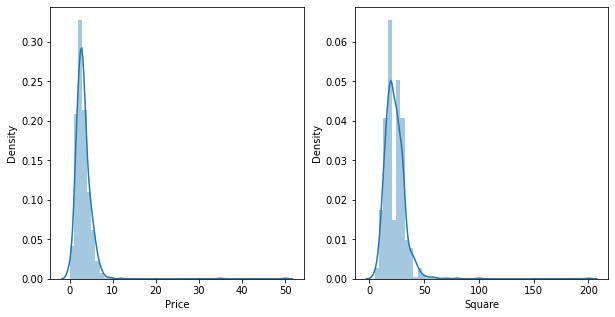

In [636]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
sns.distplot(train_df_temp[num_vars[0]].dropna())
plt.subplot(122)
sns.distplot(train_df_temp[num_vars[1]].dropna())


In [637]:
result_list=[]
for var in num_vars:
    result = univariate_cont_analysis(var, train_df_temp)
    result_list.append(result)
df_result = pd.DataFrame(result_list,columns=['mean','median','mode','max_val','min_val','range_val','variance'],
                  index=num_vars)
df_result

,mean,median,mode,max_val,min_val,range_val,variance
Price,3.213403,3.0,"0 3.0 Name: Price, dtype: float64",50.0,0.002,49.998,5.394197
Square,23.222028,22.0,"0 20.0 Name: Square, dtype: float64",200.0,5.000,195.000,106.201812


Nhận xét:
- Price chủ yếu tập trung bé hơn 10 triệu.
- Square chủ yếu tập trung dưới 50 m2.

In [638]:
# train_df_temp['Price'] = np.log(train_df_temp['Price'])
# train_df_temp['Square'] = np.log(train_df_temp['Square'])
# train_df_temp = train_df_temp[train_df_temp['Price'] < 10]
# train_df_temp = train_df_temp[train_df_temp['Square'] < 50]

## 1.8 Loại bỏ outliers


<AxesSubplot:xlabel='Square', ylabel='Price'>

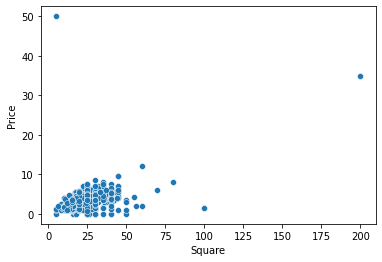

In [639]:
# Với Square
sns.scatterplot(data=train_df_temp, x='Square', y='Price')

In [640]:

# Loại bỏ các mẫu có 'Price' > 40 triệu hoặc 'Square' > 100 m2
train_df_temp.drop(train_df_temp[(train_df_temp['Price'] >= 40) | (train_df_temp['Square'] > 100)].index, inplace = True)


<AxesSubplot:xlabel='Square', ylabel='Price'>

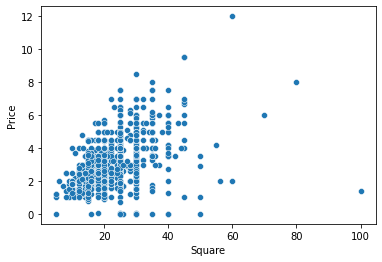

In [641]:
sns.scatterplot(data=train_df_temp, x='Square', y='Price')

In [642]:
# Tiếp tục, ta loại bỏ các mẫu có giá < 0.6 triệu
train_df_temp = train_df_temp[train_df_temp['Price'] > 0.6]

<AxesSubplot:xlabel='Square', ylabel='Price'>

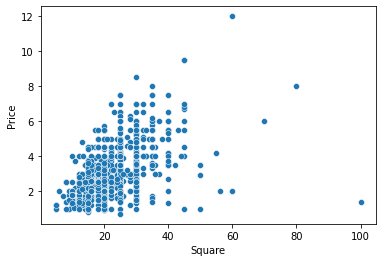

In [643]:
sns.scatterplot(data=train_df_temp, x='Square', y='Price')

In [644]:

# Loại bỏ các mẫu có 'Price' < 2 triệu và 'Square' > 40 m2
train_df_temp.drop(train_df_temp[(train_df_temp['Price'] < 2) & (train_df_temp['Square'] > 40)].index, inplace = True)


<AxesSubplot:xlabel='Square', ylabel='Price'>

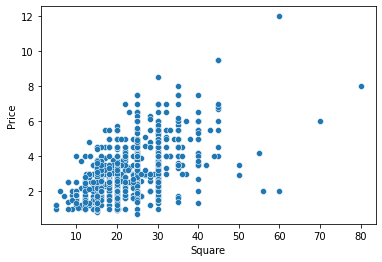

In [645]:
sns.scatterplot(data=train_df_temp, x='Square', y='Price')

In [646]:
# Loại bỏ các mẫu có 'isNew' == no và price > 9 triệu
train_df_temp.drop(train_df_temp[(train_df_temp['Price'] >= 9) & (train_df_temp['isNew'] == "no")].index, inplace = True)

# Loại bỏ các mẫu có 'isNew' == yes và price > 8 triệu
train_df_temp.drop(train_df_temp[(train_df_temp['Price'] >= 8) & (train_df_temp['isNew'] == "yes")].index, inplace = True)


<AxesSubplot:xlabel='hasFurniture', ylabel='Price'>

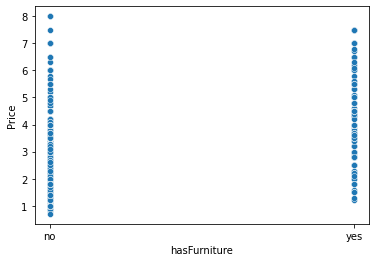

In [647]:
# Với hasFurniture
sns.scatterplot(data=train_df_temp, x='hasFurniture', y='Price')

<AxesSubplot:xlabel='liveTogether', ylabel='Price'>

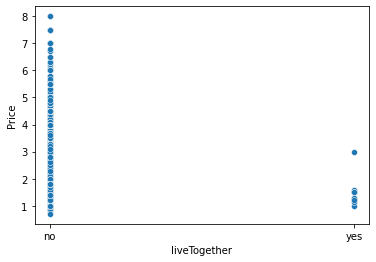

In [648]:
# Với liveTogether
sns.scatterplot(data=train_df_temp, x='liveTogether', y='Price')

In [649]:

# Loại bỏ các mẫu có 'liveTogether' == yes và price > 3
train_df_temp.drop(train_df_temp[(train_df_temp['Price'] >= 3) & (train_df_temp['liveTogether'] == "yes")].index, inplace = True)

In [650]:
n_examples = train_df_temp.shape[0]
n_features = train_df_temp.shape[1] - 3
print('Số lượng mẫu dữ liệu (samples): ', n_examples)
print('Số lượng đặc trưng (features): ', n_features)

Số lượng mẫu dữ liệu (samples):  973
Số lượng đặc trưng (features):  5


Với biến categorical, ta vẽ biểu đồ histogram để quan sát

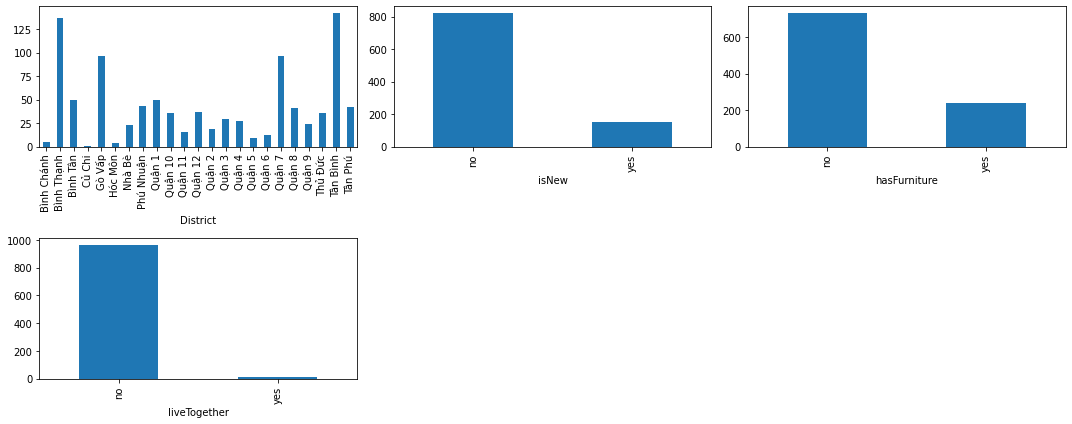

In [651]:
#Visualization - Value_count - barplot
def visualize_cat_value_count(cat_vars, train_df_temp):
    if len(cat_vars)%3 == 0:
        n = len(cat_vars)/3
    else:
        n = len(cat_vars)//3 + 1
    plt.figure(figsize=(15,6))
    for i in range (1,len(cat_vars)+1):
        count = train_df_temp.groupby(train_df_temp[cat_vars[i-1]].dropna()).size()
        plt.subplot(n,3,i)
        count.plot.bar()
    plt.tight_layout()
    plt.show()
visualize_cat_value_count(cat_vars, train_df_temp)

In [652]:
import scipy
#Chi-square test
from scipy.stats import chi2_contingency, chi2

#categgorical - categorical
def chi2_test(cat_var,df):
    chi2_test_df=pd.DataFrame(index=cat_var,columns=cat_var)
    alpha = 0.05

    for i in range (len(cat_var)):
        for j in range(i+1,len(cat_var)):
            table = pd.crosstab(df[cat_var[i]],df[cat_var[j]])
            stat, p, dof, expected = chi2_contingency(table)
            #print('\n*** significance = %.3f, p_value = %.3f' %(alpha,p))
            if p < alpha:
                #print(cat_var[i],'&',cat_var[j],'==> Dependent (Reject H0)')
                chi2_test_df.loc[cat_var[i],cat_var[j]]='Dependent'
            else:
                #print(cat_var[i],'&',cat_var[j],'==> Independent (Fail to Reject H0)')
                chi2_test_df.loc[cat_var[i],cat_var[j]]='Independent'
    return chi2_test_df 

#Chi2 Test -> tìm ra các biến category độc lập
chi2_test(cat_vars,train_df_temp)

,District,isNew,hasFurniture,liveTogether
District,NaN,Independent,Dependent,Independent
isNew,NaN,NaN,Independent,Independent
hasFurniture,NaN,NaN,NaN,Independent
liveTogether,NaN,NaN,NaN,NaN


Quyết định sử dụng các biến: Square, District, isNew, hasFurniture, liveTogether 

In [653]:
df_new = train_df_temp[['Price', 'Square', 'District', 'isNew', 'hasFurniture', 'liveTogether']]
df_new.head()

,Price,Square,District,isNew,hasFurniture,liveTogether
1,2.5,25.0,Tân Phú,no,no,no
2,3.0,20.0,Bình Thạnh,yes,no,no
3,3.3,22.0,Bình Thạnh,yes,no,no
4,2.5,13.5,Quận 7,no,no,no
5,5.6,30.0,Bình Thạnh,no,yes,no


Chuyển dữ liệu Categorical sang Numerical

In [654]:
df_new = pd.get_dummies(df_new)
df_new

,Price,Square,District_Bình Chánh,District_Bình Thạnh,District_Bình Tân,District_Củ Chi,District_Gò Vấp,District_Hóc Môn,District_Nhà Bè,District_Phú Nhuận,...,District_Quận 9,District_Thủ Đức,District_Tân Bình,District_Tân Phú,isNew_no,isNew_yes,hasFurniture_no,hasFurniture_yes,liveTogether_no,liveTogether_yes
1,2.5,25.0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,1,0
2,3.0,20.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
3,3.3,22.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
4,2.5,13.5,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
5,5.6,30.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,1.0,12.0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
1122,5.5,33.0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,1,0
1123,3.1,15.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1124,3.6,15.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0


## 1.9 Trộn dữ liệu, tách independent/dependent variable, chuẩn hóa dữ liệu

In [655]:
# Trộn (shuffle) dữ liệu
np.random.seed(1) # Cố định kết quả random 
df_new = np.random.permutation(df_new)

X = df_new[:, 1:] # dependent variable
y = df_new[:, 0] # indepent variable

scaler = MinMaxScaler() # sử dụng Min Max Normalization để đưa khoảng giá trị về [0;1], vì giá và diện tích không bị âm.
scaler.fit_transform(X, y)

array([[0.17333333, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.17333333, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.2       , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.2       , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ]])

## 1.10 Chia tập Train/Val/Test

In [656]:
# Khai báo tỉ lệ kích thước của tập train/val/test (không nhất thiết khai báo cho test)
TRAIN_SIZE = 0.7
VAL_SIZE = 0.2

# Tính chỉ mục kết thúc của train, test
TRAIN_IDX_END = int(TRAIN_SIZE * df_new.shape[0])
VAL_IDX_END = int(TRAIN_IDX_END + (VAL_SIZE * df_new.shape[0]))

# Chia train/val/test sử dụng kĩ thuật indexing
X_train, y_train = X[:TRAIN_IDX_END], y[:TRAIN_IDX_END]
X_val, y_val = X[TRAIN_IDX_END:VAL_IDX_END], y[TRAIN_IDX_END:VAL_IDX_END]
X_test, y_test = X[VAL_IDX_END:], y[VAL_IDX_END:]

# 2. Xây dựng, huấn luyện, đánh giá model

In [657]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xgb

In [658]:
model1 = LinearRegression()
model1.fit(X_train, y_train)
val = model1.predict(X_val)
test = model1.predict(X_test)


print("Best validation score: ", np.round(r2_score(y_val, val), 3))
print("Best test score: ", np.round(r2_score(y_test, test), 3))

Best validation score:  0.564
Best test score:  0.551


In [659]:
model1 = RandomForestRegressor()
model1.fit(X_train, y_train)
val = model1.predict(X_val)
test = model1.predict(X_test)

print("Best validation score: ", np.round(r2_score(y_val, val), 3))
print("Best test score: ", np.round(r2_score(y_test, test), 3))

Best validation score:  0.581
Best test score:  0.442


In [660]:
model1 = KNeighborsRegressor()
model1.fit(X_train, y_train)
val = model1.predict(X_val)
test = model1.predict(X_test)


print("Best validation score: ", np.round(r2_score(y_val, val), 3))
print("Best test score: ", np.round(r2_score(y_test, test), 3))

Best validation score:  0.481
Best test score:  0.255


In [661]:
model1 = xgb.XGBRegressor(verbosity=0)
model1.fit(X_train, y_train)
val = model1.predict(X_val)
test = model1.predict(X_test)


print("Best validation score: ", np.round(r2_score(y_val, val), 3))
print("Best test score: ", np.round(r2_score(y_test, test), 3))

Best validation score:  0.54
Best test score:  0.445
